In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_75206/409395300.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-07-04 17:19:48.417730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ss

In [2]:
df = pd.read_csv('/Users/edoardozappia/Downloads/creditcard.csv')

In [3]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [4]:
data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

print(X_train.shape)

#y_test = X_test['Class']
#X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#X_test = X_test.values

(227451, 29)


In [6]:
class_0 = X_test[X_test.Class == 0]
class_1 = X_test[X_test.Class == 1]

total_size = len(X_test)
desired_size_class_1 = int(total_size * 0.4)
desired_size_class_0 = total_size - desired_size_class_1

class_1_sampled = class_1.sample(n=desired_size_class_1, replace=True, random_state=42)
class_0_sampled = class_0.sample(n=desired_size_class_0, replace=True, random_state=42)

balanced_data = pd.concat([class_0_sampled, class_1_sampled])

X_test = balanced_data.drop('Class', axis=1)
y_test = balanced_data['Class']

X_test = X_test.values

In [7]:
print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))

34178
22784


In [8]:
input_dim = X_train.shape[1]
#encoding_dim = 14

In [9]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(18, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(9, activation='relu')(encoder)

decoder = Dense(18, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [11]:
nb_epoch = 100
batch_size = 20000

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
                    
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [12]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.0413 - loss: 19.7499 - val_accuracy: 0.0356 - val_loss: 34.3618
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0536 - loss: 19.0350 - val_accuracy: 0.0429 - val_loss: 33.8753
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0661 - loss: 18.3202 - val_accuracy: 0.0682 - val_loss: 33.3882
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0892 - loss: 17.6327 - val_accuracy: 0.0999 - val_loss: 32.8807
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1125 - loss: 16.8560 - val_accuracy: 0.1222 - val_loss: 32.3434
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1490 - loss: 16.0418 - val_accuracy: 0.1562 - val_loss: 31.7702
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1994 - loss: 15.2593 - val_accuracy: 0.1847 - val_loss: 31.1268
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2422 - loss: 14.4005 - v

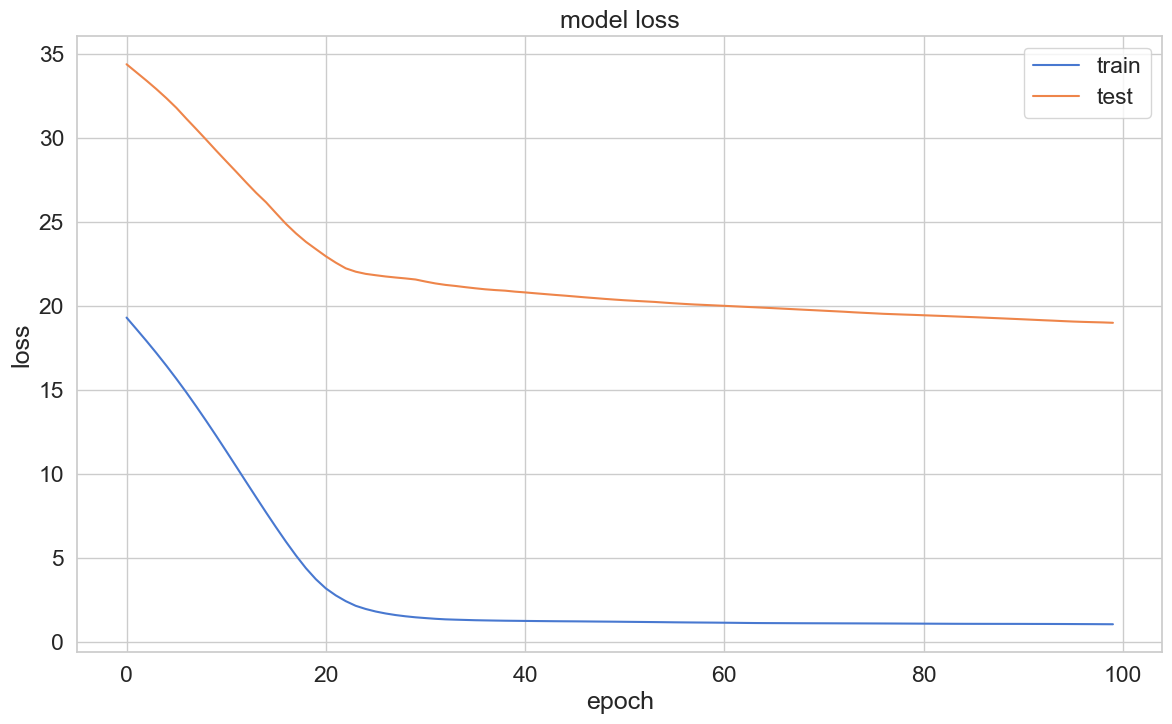

In [14]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [15]:
predictions = autoencoder.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [16]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'y_true': y_test})

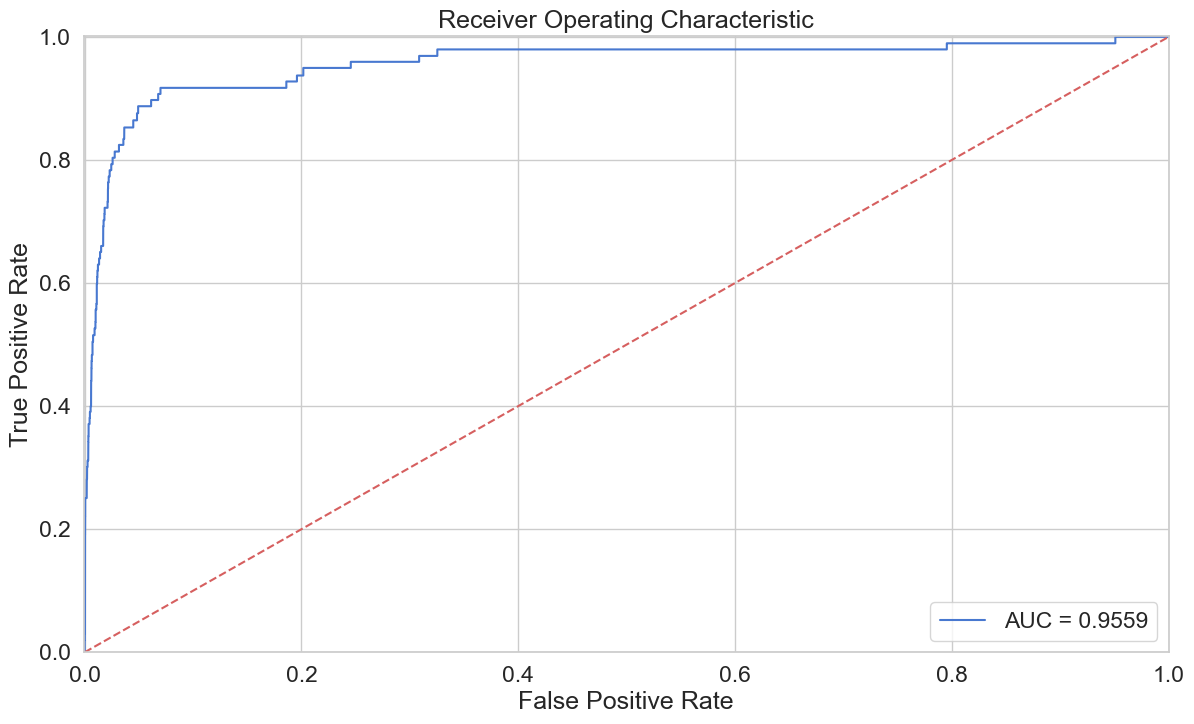

In [21]:
fpr, tpr, thresholds = roc_curve(error_df.y_true, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [25]:
def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['reconstruction_error'].quantile(i/iterations)
        preds = df['reconstruction_error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(error_df, 10)

Threshold: 0.1556	Accuracy: 0.400		Precision: 0.700	Recall Score: 0.500
Threshold: 0.3388	Accuracy: 0.492		Precision: 0.699	Recall Score: 0.575
Threshold: 0.4515	Accuracy: 0.584		Precision: 0.724	Recall Score: 0.650
Threshold: 0.5976	Accuracy: 0.684		Precision: 0.766	Recall Score: 0.733
Threshold: 0.7950	Accuracy: 0.784		Precision: 0.816	Recall Score: 0.816
Threshold: 1.0538	Accuracy: 0.854		Precision: 0.853	Recall Score: 0.868
Threshold: 1.7323	Accuracy: 0.919		Precision: 0.915	Recall Score: 0.915
Threshold: 4.8301	Accuracy: 0.878		Precision: 0.902	Recall Score: 0.852
Threshold: 10.5601	Accuracy: 0.789		Precision: 0.860	Recall Score: 0.738
Threshold: 58.2696	Accuracy: 0.696		Precision: 0.830	Recall Score: 0.620


In [26]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 1.732277


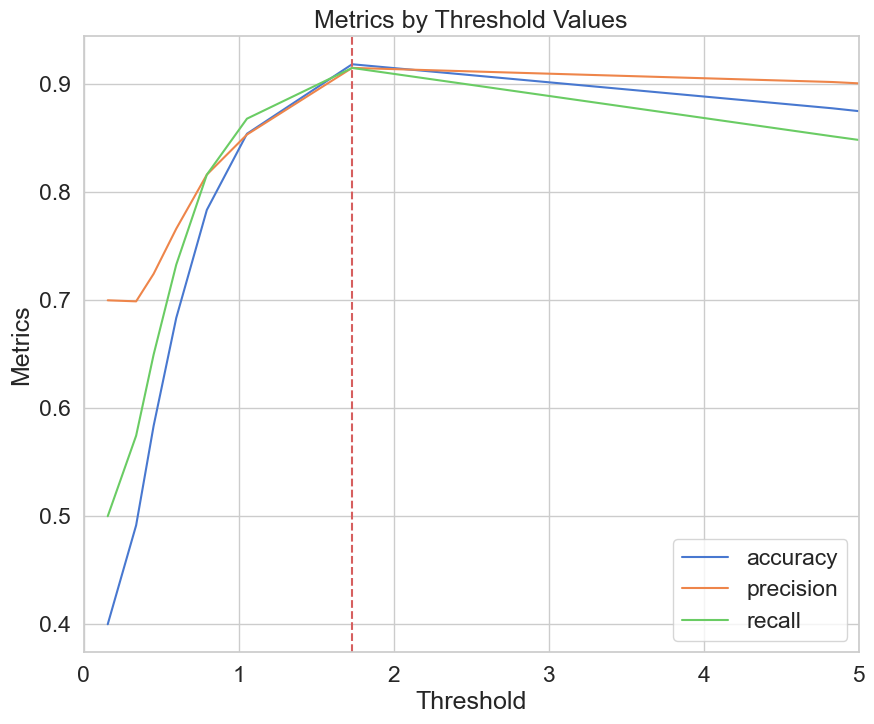

In [27]:
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlim(0, 5)
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

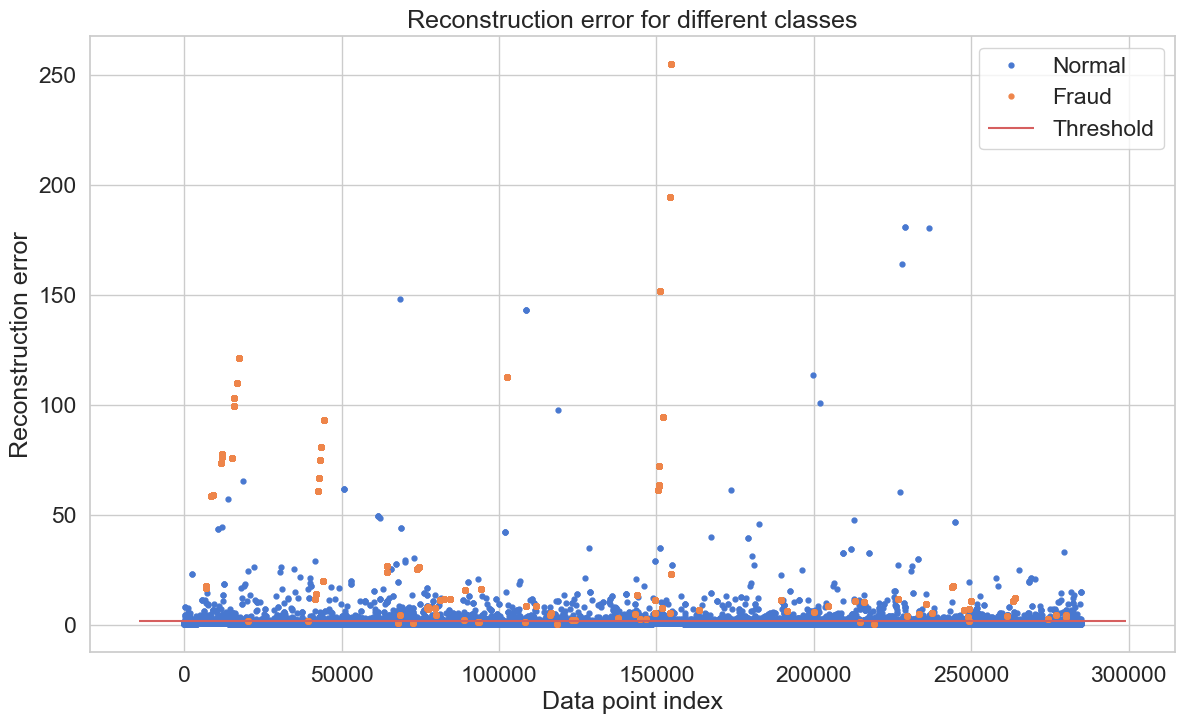

In [28]:
groups = error_df.groupby('y_true')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

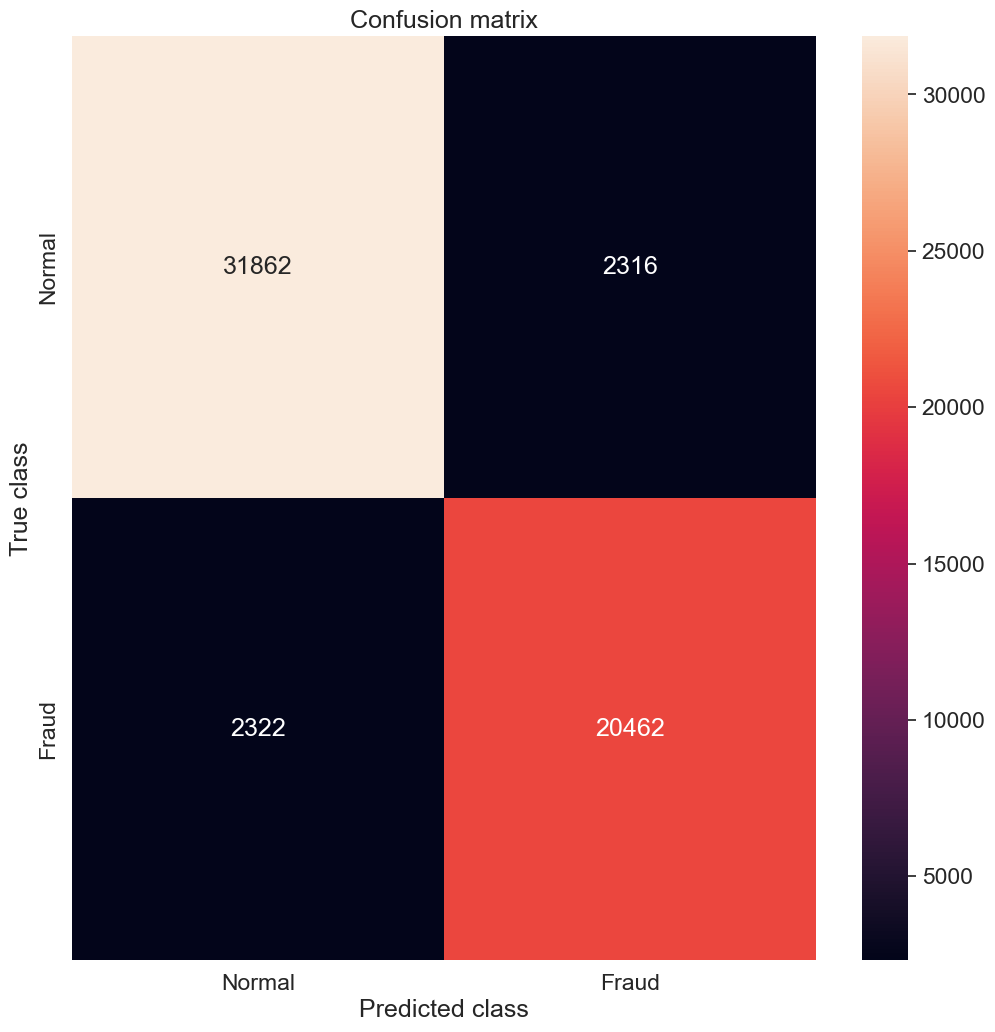

In [29]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.y_true, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [30]:
def metrics(cm):
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"True Positives (TP) = {tp}")
    print(f"True Negatives (TN) = {tn}")
    print(f"False Positives (FP) = {fp}")
    print(f"False Negatives (FN) = {fn}")

In [31]:
metrics(conf_matrix)

Accuracy = 0.9185772971454654
Precision = 0.8983229431907981
Recall = 0.8980863764044944
True Positives (TP) = 20462
True Negatives (TN) = 31862
False Positives (FP) = 2316
False Negatives (FN) = 2322
